In [1]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

from qiskit_ode.dispatch import Array
from qiskit_ode.signals.signals import (Signal, 
                                            Constant, 
                                            PiecewiseConstant, 
                                            SignalSum, 
                                            PiecewiseConstantSignalSum,
                                            SignalList)

# rename: PiecewiseConstant -> DiscreteSignal

This demo shows some of the changes/features of the current PR.

General notes:
- Frequency shift function in signals (preserve signal, but just shift `carrier_freq`)
- FFT function (Method of class, or independent function? Return types?)
- For `__getitem__`, would be nice to have fancy numpy-style indexing, e.g. `sig_sum[0]`, or `sig_sum[[0, 2]]` to get a subsum. For `SignalList` similar, but return another `SignalList`. Check out `PauliList` class in Chris' PR. Treat these as 1d arrays (i.e. only worry about 1d indexing).

# 1. Method name changes

In [2]:
sig1 = Signal(lambda t: t, carrier_freq=0.1)

`__call__` evalutes the real part:

In [3]:
sig1(4.5)

-4.2797543233281905

To evaluate the complex value, the method is now called `complex_value` to be explicit.

In [4]:
sig1.complex_value(4.5)

(-4.2797543233281905+1.3905764746872638j)

`envelope_value` changed to `envelope`

In [5]:
sig1.envelope(4.5)

4.5

# 2. Vectorized `Signal` evaluation

Internally everything is now written to work with arrays of time values. We now assume that the envelope function is vectorized. If not, the user can use `np.vectorize` or `jax.vmap` to vectorize the evaluation.

## 2.1 Already vectorized envelopes

The envelope we defined for `sig1` is vectorized.

In [6]:
print(sig1(np.array([2., 3.])))

[ 0.61803399 -0.92705098]


In [7]:
print(sig1(np.array([[1., 2., 3.], [4., 5., 6.]])))

[[ 0.80901699  0.61803399 -0.92705098]
 [-3.23606798 -5.         -4.85410197]]


## 2.2 Non-vectorized envelopes

If a user written function is not vectorized, they can specify that it needs to be vectorized at construction.

Note: Force user to vectorize before putting it in.

In [8]:
def nonvectorized_func(t):
    if t < 1.:
        return t
    else:
        return 50.

vectorized_func = np.vectorize(nonvectorized_func)    

sig2 = Signal(vectorized_func, carrier_freq=1.0)

This function is not vectorized, so raises an error when we try to call it on an array:

In [9]:
nonvectorized_func(np.array([0.5, 2.]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

``sig2`` however has internally vectorized the function, so it works on arrays:

In [10]:
print(sig2.envelope(np.array([0.5, 2.])))
print(sig2(np.array([0.5, 2.])))

[ 0.5 50. ]
[-0.5 50. ]


# 3. Plotting

Plotting is essentially unchanged.

Notes:
- Return axis object?
- Defaults: add a grid
- Defaults: Add legend for real/imaginary
- Change plot -> draw
  - single function, specify which thing is being drawn with a kwarg, e.g. `method='envelope'`

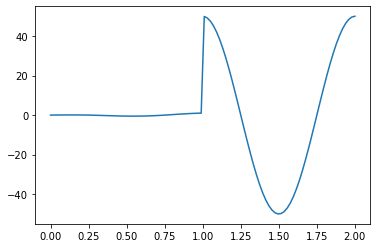

In [11]:
sig2.plot(0, 2, 100)

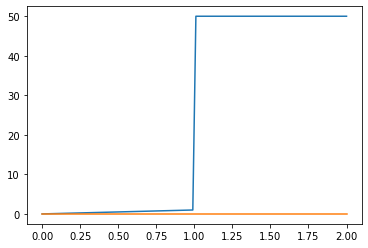

In [12]:
sig2.plot_envelope(0, 2, 100)

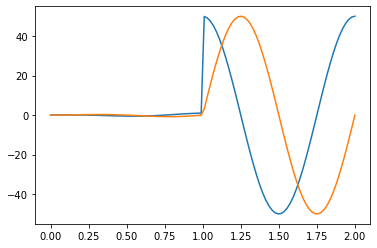

In [13]:
sig2.plot_complex_value(0, 2, 100)

# 4. string rep

If a name is present, `str` returns the name, otherwise it indicates the carrier frequency and phase.

Notes:
- Make repr look a bit like the default but a bit more concise

In [14]:
str(sig2)

'Signal(carrier_freq=1.0, phase=0.0)'

In [15]:
sig2._name = 'new_name'
str(sig2)

'new_name'

# 5. ``SignalSum``

The ``SignalSum`` object represents a sum of signals. It is a subclass of `Signal` (so implements the same interface), but interally stores a list of signals to sum together.

In [16]:
sig1 = Signal(lambda t: t + t**2 * 1j, carrier_freq=1.)
sig2 = Signal(lambda t: -t, carrier_freq=2.)

sig_sum = sig1 + sig2
str(sig_sum)

'Signal(carrier_freq=1.0, phase=0.0) + Signal(carrier_freq=2.0, phase=0.0)'

Vectorized evaluation works:

In [17]:
t = 0.2
print(sig_sum(t))
print(sig1(t) + sig2(t))

0.18556453709817283
0.18556453709817283


In [18]:
t = np.array([[1.1, 0.2], [4.6, 4.7]])
print(sig_sum(t))
print(sig1(t) + sig2(t))

[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]
[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]


The envelope function returns an array of the envelopes of each term in the sum:

In [19]:
print(sig_sum.envelope(2.))
print(np.array([sig1.envelope(2.), sig2.envelope(2.)]))

[ 2.+4.j -2.+0.j]
[ 2.+4.j -2.+0.j]


The `components` attribute stores the list of signals in the sum, which can be accessed via subscripting of the `SignalSum`.

In [20]:
print(sig_sum[0](1.1))
print(s(1.1))

0.17869853853854856


NameError: name 's' is not defined

We can still plot:

In [ ]:
sig_sum.plot(0, 1, 100)

In [ ]:
sig_sum.plot_complex_value(0, 1, 100)

Currently plotting of envelope plots all components. Looks kind of cool, though not really sure what to do with this.

In [ ]:
sig_sum.plot_envelope(0, 1, 100)

# 6. SignalSum.collapse()

This function merges all signals in a `SignalSum` into a single base `Signal`. This will be useful when migrating to using `SignalSum`s, for functionality that assumes a `Signal` as input.

- Notes:
    - change collapse -> flatten, reduce 

In [ ]:
sig1 = Signal(1., carrier_freq=2.)
sig2 = Signal(2., carrier_freq=3.)
sig_sum = sig1 + sig2

Collapsing returns a single signal with frequencies averaged.

In [ ]:
sig_collapse = sig_sum.collapse()
type(sig_collapse)

In [ ]:
sig_collapse(1.2)

In [ ]:
sig_collapse.carrier_freq

# 7. Constant and PiecewiseConstant

These have remained the same from a user perspective, with minor modifications internally to support vectorized evaluation.

In [ ]:
const = Constant(3.)
const(np.array([1., 1.]))

In [ ]:
sig = PiecewiseConstant(dt=1., samples=np.array([1., 2., 3.]), carrier_freq=0.5)
sig(np.array([2.1, 1.1]))

# 8. Multiplication

Multiplication is implemented by creating a `SignalSum` giving the right-hand side of:
\begin{equation}
    Re[f(t)\exp(i(\omega t + \phi))] \times Re[g(t) \exp(i (\nu t + \psi))] = Re\left[\frac{1}{2}f(t)g(t)\exp(i((\omega + \nu) t + (\phi + \psi))\right] + Re\left[\frac{1}{2}f(t)\overline{g(t)}\exp(i((\omega - \nu) t + (\phi - \psi))\right]
\end{equation}

In [ ]:
sig_prod = sig1 * sig2

In [ ]:
print(sig1.carrier_freq)
print(sig2.carrier_freq)

`carrier_freq` attribute of a signal sum now returns the array of carrier frequencies for each term in the sum. For the product, we see two freqs, one at the sum and one at the difference of the terms in the product.

In [ ]:
sig_prod.carrier_freq

In [ ]:
sig_prod(1.1) - (sig1(1.1) * sig2(1.1))

In [ ]:
sig_prod.plot(0., 1., 100)

## 8.1 Special multiplication rules

Special rules are internally implemented for multiplication depending on the type of the signals.

Constants have their internal values multiplied

In [ ]:
const_prod = Constant(3.) * Constant(2.)
str(const_prod)

PiecewiseConstants with compatible parameters (start time, dt, and number of samples) are implemented via array multiplication.

In [ ]:
pwc_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
            PiecewiseConstant(dt=0.1, samples=np.array([4.,5.,6.]), carrier_freq=2.))
str(pwc_prod)

Multiplying a constant by a single signal only returns a single signal (as the constant is gauranteed to have fourier spectrum centred at $0$).

In [ ]:
const_sig_prod = 3. * Signal(lambda t: t, carrier_freq=1.)
str(const_sig_prod)

For pairs for which special handling doesn't apply, generic Signals are returned.

In [ ]:
general_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
               Signal(envelope=lambda t: t, carrier_freq=2.))
print(str(general_prod))
general_prod(0.02) - (np.cos(2 * np.pi * 0.02) * 0.02 * np.cos(2 * np.pi * 2. * 0.02))

# 9. PiecewiseConstantSignalSum

For situations with full-array based signal computation, we have the `PiecewiseConstantSignalSum` object, which represents a sum in which all components are `PiecewiseConstant` with consistent sample structure: same `dt`, same `start_time`, and same `duration`. This inherits from both `SignalSum` and `PiecewiseConstant`. Internally, all signal samples are stored in a single `Array`, and envelope evaluation is done with a single lookup in this array.

In [ ]:
samples = np.array([[1., 2., 3.], [4, 5., 6.], [7., 8., 9.]])
freqs = np.array([1., 2., 3.])
dt = 1.

sig_sum = PiecewiseConstantSignalSum(dt=dt, samples=samples, carrier_freqs=freqs)

In [ ]:
sig_sum(2.1)

In [ ]:
sig_sum[0](2.1) + sig_sum[1](2.1) + sig_sum[2](2.1)

In [ ]:
sig_sum(np.array([1., 2.1, 2.9]))

If two `PiecewiseConstant`s with consistent structure, when added together, will automatically produce a `PiecewiseConstantSignalSum`.

In [ ]:
sig1 = PiecewiseConstant(dt=0.5, samples=[1., 2., 3., 4.], carrier_freq=3.)
sig2 = PiecewiseConstant(dt=0.5, samples=[5., 6., 7., 8.], carrier_freq=2.)

sig_sum = sig1 + sig2
type(sig_sum)

In [ ]:
sig_sum.samples

In [ ]:
sig_sum(0.1) - (sig1(0.1) + sig2(0.1))

In [ ]:
double_sum = sig_sum + sig_sum
type(double_sum)

In [ ]:
double_sum(0.1) - 2 * (sig1(0.1) + sig2(0.1))

# 10. `to_pwc`

The `to_pwc` function already exists in `Signal`, but we have now added an optional argument for whether to discretize just the envelope, or the whole signal (including the carrier).

Notes:
- Maybe change name to discretize
- Change this to a class method of PiecewiseConstant/DiscreteSignal

In [ ]:
sig = Signal(lambda t: t, carrier_freq=2.)

disc1 = sig.to_pwc(dt=0.1, start_time=0., n_samples=10)
disc2 = sig.to_pwc(dt=0.1, start_time=0., n_samples=10, sample_carrier=True)

Comparison with non-discretized carrier:

In [ ]:
sig.plot(0, 1, 100)
disc1.plot(0, 1, 100)

Comparison with discretized carrier:

In [ ]:
sig.plot(0, 1, 100)
disc2.plot(0, 1, 100)

For the signal with sampled carrier, the carrier frequency has been set to 0 (all oscillations are now in the samples):

In [ ]:
disc2.carrier_freq

## 10.1 `SignalSum.to_pwc`

`SignalSum` also has a `to_pwc` method that discretize all components uniformly and returns a `PiecewiseConstantSignalSum`.

In [ ]:
sig1 = Signal(lambda t: t, carrier_freq=2.)
sig2 = Signal(lambda t: 1j * t**2, carrier_freq=3.)
sig_sum = sig1 + sig2

In [ ]:
disc1 = sig_sum.to_pwc(dt=0.1, start_time=0., n_samples=10)
disc2 = sig_sum.to_pwc(dt=0.1, start_time=0., n_samples=10, sample_carrier=True)

In [ ]:
sig_sum.plot(0, 1, 100)
disc1.plot(0, 1, 100)

In [ ]:
sig_sum.plot(0, 1, 100)
disc2.plot(0, 1, 100)

# 11. Example: IQ Mixer via signal algebra

Here we implement the operations for modelling an IQ mixer via signal multiplication and addition.

In [ ]:
# define some envelope function
def env(t):
    return t * (1 - t)

w_d = 2.
w_lo = 1.9
w_if = 0.1

I = Signal(env, carrier_freq=w_if, name='I').to_pwc(dt=0.1, start_time=0, n_samples=10) # envelope times cosine at w_if
Q = Signal(env, carrier_freq=w_if, phase=-np.pi/2, name='Q').to_pwc(dt=0.1, start_time=0, n_samples=10) # envelope times sine at w_if

slo_I = Signal(1., carrier_freq=w_lo, name='slo_I') # local oscillator for I
slo_Q = Signal(1., carrier_freq=w_lo, phase=-np.pi/2, name='slo_Q') # local oscillator for Q

The IQ output is a sum of two products. Hence, it produces a `SignalSum` with 4 outputs.

In [ ]:
IQ_output = (I * slo_I) - (Q * slo_Q)
str(IQ_output)

In [ ]:
IQ_output.plot(0, 1, 100)

The $0^{th}$ and $2^{nd}$ terms in the sum are at frequency `2.0`, which we can plot:

In [ ]:
(IQ_output[0] + IQ_output[2]).plot(0, 1, 100)

The $1^{st}$ and $3^{rd}$ terms are at frequency `1.8`:

In [ ]:
(IQ_output[1] + IQ_output[3]).plot(0, 1, 100)

This demonstrates the cancellation at the lower sideband, with the remaining signal at the upper sideband.

## 12. `SignalList`

Finally, we need to update/replace `VectorSignal` to work with `SignalSum`s and vectorized operations.

Currently `VectorSignal` assumes that each component is a base `Signal` (i.e. a single term with a single carrier freq and phase). Ideally we could expand this to represent a list of `SignalSum`s, but it's a bit awkward as each `SignalSum` may be a different length (so it is unclear how to vectorize evaluation of frequency/phases across all signals at once). 

I don't know what the best thing is here, but for now I've written a very small `SignalList` class that stores/evaluates a list of `SignalSum` components. At the very least there should be a `PiecewiseConstant` variant of `SignalList`/`VectorSignal` for fully array-based evaluation.

Notes:
- Algebraic operations should be like numpy broadcasting - e.g. multiplicatino can do a list $\times$ single signal, or list $\times$ list, and similar for addition
- Plotting can be like envelope plotting in `SignalSum`

In [ ]:
sig1 = Signal(lambda t: t, carrier_freq=2.)
sig2 = Signal(lambda t: 1j * t**2, carrier_freq=3.)
sig_list = SignalList([sig1, sig2])

Vectorized evaluation

In [ ]:
sig_list(np.array([1.1, 1.2]))

In [ ]:
sig1(np.array([1.1, 1.2]))

In [ ]:
sig2(np.array([1.1, 1.2]))